# Filtering thymus 111 data (positive selection cells)

Zoë Steier

* Datasets: Berkeley (ZRS06, ZRS07) and BioLegend (ZRS08) filtered for cells undergoing positive selection (DP to SP)
* Filter cells in thymus 111 data separately for Berkeley and BioLegend cohorts
* Filter genes (variable gene selection considering batch, plus additional genes of interest)

## Imports and settings

In [1]:
# Import required packages

import csv
import gzip
import os
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch

import scvi
from scvi.dataset import GeneExpressionDataset, CellMeasurement, AnnDatasetFromAnnData
from scvi.models import VAE, TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer, Posterior, UnsupervisedTrainer

import anndata
import scanpy as sc
import umap

%load_ext autoreload
%autoreload 2
%matplotlib inline

scvi.set_seed(0)

/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_065/lib/python3.7/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


In [2]:
# Plotting settings

colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set(context="notebook", font_scale=1.3, style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
sc.settings._vector_friendly = True
import matplotlib.colors as mcolors
DPI = 300

## Load data

* Load all data
* Subset cells to those undergoing positive selection
* Find new highly variable genes

### Load positive selection data

In [3]:
all_data_path = "/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/totalVI_thymus/thymus111_allbatches_stable/"

In [4]:
post_adata = anndata.read(all_data_path + "posterior_adata.h5ad")

In [6]:
post_adata.shape

(72042, 5125)

In [7]:
# Subset on positive selection cells
Posclusters = [cluster in ["1", "2", "4", "5", "6", "11", "15"] for cluster in post_adata.obs["leiden_totalVI_res0.6"]]

Trying to set attribute `.uns` of view, copying.


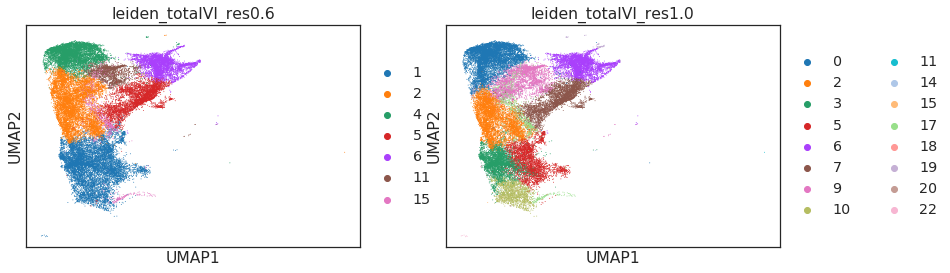

In [8]:
sc.pl.umap(
    post_adata[Posclusters, :], 
    color=["leiden_totalVI_res0.6", "leiden_totalVI_res1.0"],
    ncols = 2)

In [9]:
# Subset anndata to posclusters
pos_adata = post_adata[Posclusters, :]
pos_adata.shape

(35943, 5125)

### Load BioLegend data (starting from full gene set)

In [10]:
# Load data path for BioLegend (8 lanes)

save_path_BioLegend = "/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/cellranger_aggr/ZRS08_thymus111_aggr/outs/filtered_feature_bc_matrix"

In [11]:
# Load data with scanpy
dataset_BioLegend = sc.read_10x_mtx(save_path_BioLegend, gex_only=False)
dataset_BioLegend.obsm["protein_expression"] = dataset_BioLegend[
    :, dataset_BioLegend.var["feature_types"] == "Antibody Capture"].X.A
dataset_BioLegend.uns["protein_names"] = np.array(
    dataset_BioLegend.var_names[dataset_BioLegend.var["feature_types"] == "Antibody Capture"])
dataset_BioLegend = dataset_BioLegend[
    :, dataset_BioLegend.var["feature_types"] != "Antibody Capture"].copy()
dataset_BioLegend.X = dataset_BioLegend.X.A
dataset_BioLegend.var_names_make_unique()

In [12]:
# Add batch labels
# Add the +11 to distinguish from the Berkeley batch indices
dataset_BioLegend.obs["batch_indices"] = [int(b.split("-")[1]) - 1 + 11 for b in dataset_BioLegend.obs.index]

In [13]:
dataset_BioLegend

AnnData object with n_obs × n_vars = 42406 × 28692
    obs: 'batch_indices'
    var: 'gene_ids', 'feature_types'
    uns: 'protein_names'
    obsm: 'protein_expression'

In [14]:
# Find proteins to keep
protein_names = pd.read_csv("/data/yosef2/users/zsteier/totalVI/totalVI_journal/data/metadata/protein_metadata/TotalSeq_ADT206_ADT111_matched.csv")
protein_to_rna_table = pd.read_csv("/data/yosef2/users/zsteier/totalVI/totalVI_journal/data/metadata/protein_metadata/TotalSeq_ADT111_barcodes_RNA_20190717.csv")

# Subset on proteins included in this panel
subset_111 = protein_names["name_206"][~protein_names["name_111"].isnull()].values
keep = []
for i, p in enumerate(dataset_BioLegend.uns["protein_names"]):
    if p in subset_111:
        keep.append(i)
dataset_BioLegend.obsm["protein_expression"] = dataset_BioLegend.obsm["protein_expression"][:, keep]
dataset_BioLegend.uns["protein_names"] = dataset_BioLegend.uns["protein_names"][keep]

# Some genes encode multiple protein so it's ok to overwrite key in this case as it will be included downstream
protein_111_names = protein_names["name_111"][
    ~protein_names["name_111"].isnull()
].values
g_to_p = {}
for p1, p2 in zip(protein_111_names, subset_111):
    ind = np.where(protein_to_rna_table["name"] == p1)[0]
    g_to_p[str(protein_to_rna_table.loc[ind, "RNA"].values[0])] = p2

In [15]:
# Calculate mitochondrial reads
mito_genes = dataset_BioLegend.var_names.str.startswith("mt-")
dataset_BioLegend.obs["percent_mito"] = np.sum(dataset_BioLegend[:, mito_genes].X, axis=1) / np.sum(dataset_BioLegend.X, axis=1)
dataset_BioLegend.obs['n_counts'] = dataset_BioLegend.X.sum(axis=1)

In [17]:
# calculate protein library size
dataset_BioLegend.obs["n_protein_counts"] = dataset_BioLegend.obsm["protein_expression"].sum(axis=1)

In [18]:
# Calculate number of proteins detected per cell
dataset_BioLegend.obs["n_proteins"] = (dataset_BioLegend.obsm["protein_expression"] > 0).sum(axis=1)

In [19]:
dataset_BioLegend

AnnData object with n_obs × n_vars = 42406 × 28692
    obs: 'batch_indices', 'percent_mito', 'n_counts', 'n_protein_counts', 'n_proteins'
    var: 'gene_ids', 'feature_types'
    uns: 'protein_names'
    obsm: 'protein_expression'

### Load Berkeley data (starting from full gene set)

In [20]:
# Load data path for Berkeley data

save_path_Berkeley = "/data/yosef2/users/zsteier/TotalSeq/20190718_NovaSeq_ZRS07/ZRS07_ZRS06_aggr_nonorm/outs/filtered_feature_bc_matrix"

In [21]:
# Load data with scanpy
dataset_Berkeley = sc.read_10x_mtx(save_path_Berkeley, gex_only=False)
dataset_Berkeley.obsm["protein_expression"] = dataset_Berkeley[
    :, dataset_Berkeley.var["feature_types"] == "Antibody Capture"].X.A
dataset_Berkeley.uns["protein_names"] = np.array(
    dataset_Berkeley.var_names[dataset_Berkeley.var["feature_types"] == "Antibody Capture"])
dataset_Berkeley = dataset_Berkeley[
    :, dataset_Berkeley.var["feature_types"] != "Antibody Capture"].copy()
dataset_Berkeley.X = dataset_Berkeley.X.A
dataset_Berkeley.var_names_make_unique()

In [22]:
# Add batch labels (substract 1 to start indexing at 0)
dataset_Berkeley.obs["batch_indices"] = [int(b.split("-")[1]) - 1 for b in dataset_Berkeley.obs.index]

In [23]:
dataset_Berkeley

AnnData object with n_obs × n_vars = 42983 × 28692
    obs: 'batch_indices'
    var: 'gene_ids', 'feature_types'
    uns: 'protein_names'
    obsm: 'protein_expression'

In [24]:
# Find proteins to keep
protein_names = pd.read_csv("/data/yosef2/users/zsteier/totalVI/totalVI_journal/data/metadata/protein_metadata/TotalSeq_ADT206_ADT111_matched.csv")
protein_to_rna_table = pd.read_csv("/data/yosef2/users/zsteier/totalVI/totalVI_journal/data/metadata/protein_metadata/TotalSeq_ADT111_barcodes_RNA_20190717.csv")

# Subset on proteins included in this panel
subset_111 = protein_names["name_111"][~protein_names["name_111"].isnull()].values # Berkeley dataset has 111 names
keep = []
for i, p in enumerate(dataset_Berkeley.uns["protein_names"]):
    if p in subset_111:
        keep.append(i)
dataset_Berkeley.obsm["protein_expression"] = dataset_Berkeley.obsm["protein_expression"][:, keep]
dataset_Berkeley.uns["protein_names"] = dataset_Berkeley.uns["protein_names"][keep]

# Some genes encode multiple protein so it's ok to overwrite key in this case as it will be included downstream
protein_111_names = protein_names["name_111"][
    ~protein_names["name_111"].isnull()
].values
g_to_p = {}
for p1, p2 in zip(protein_111_names, subset_111):
    ind = np.where(protein_to_rna_table["name"] == p1)[0]
    g_to_p[str(protein_to_rna_table.loc[ind, "RNA"].values[0])] = p2

In [25]:
# Calculate mitochondrial reads
mito_genes = dataset_Berkeley.var_names.str.startswith("mt-")
dataset_Berkeley.obs["percent_mito"] = np.sum(dataset_Berkeley[:, mito_genes].X, axis=1) / np.sum(dataset_Berkeley.X, axis=1)
dataset_Berkeley.obs['n_counts'] = dataset_Berkeley.X.sum(axis=1)

In [26]:
# Calculate protein library size
dataset_Berkeley.obs["n_protein_counts"] = dataset_Berkeley.obsm["protein_expression"].sum(axis=1)

In [29]:
# Rename proteins in Berkeley dataset to match the BioLegend 206 names
berkeley_renamed = []
for name111 in dataset_Berkeley.uns["protein_names"]:
    newname = protein_names.iloc[np.where(protein_names["name_111"] == name111)]["name_206"].values[0]
    berkeley_renamed.append(newname)
                                               
berkeley_renamed = np.array(berkeley_renamed)
dataset_Berkeley.uns["protein_names"] = berkeley_renamed 

In [31]:
# Rearrange Berkeley protein expression data in the same order as the BioLegend data
berkeley_prot_expression = pd.DataFrame(dataset_Berkeley.obsm["protein_expression"], 
                                        columns = dataset_Berkeley.uns["protein_names"])

berkeley_prot_rearranged = berkeley_prot_expression[dataset_BioLegend.uns["protein_names"]]

dataset_Berkeley.obsm["protein_expression"] = np.asarray(berkeley_prot_rearranged)

In [32]:
# Reorder protein_names to match protein_expression
dataset_Berkeley.uns["protein_names"] = berkeley_prot_rearranged.columns.values

In [34]:
# Calculate number of proteins detected per cell
dataset_Berkeley.obs["n_proteins"] = (dataset_Berkeley.obsm["protein_expression"] > 0).sum(axis=1)

In [35]:
dataset_Berkeley

AnnData object with n_obs × n_vars = 42983 × 28692
    obs: 'batch_indices', 'percent_mito', 'n_counts', 'n_protein_counts', 'n_proteins'
    var: 'gene_ids', 'feature_types'
    uns: 'protein_names'
    obsm: 'protein_expression'

## Find highly variable genes and genes of interest

### Find genes of interest
Genes are related to TCR signaling pathways and fate commitment

In [37]:
# Load two lists of genes of interest (genes are related to TCR signaling pathways and fate commitment)
Laura_genes = pd.read_csv(all_data_path + "Laura_genes_of_interest.csv")
Laura_genes = np.asarray([gene.lower().capitalize() for gene in Laura_genes.Gene])
ZRS_genes = np.array(pd.read_csv(all_data_path + "ZRS_genes_of_interest.csv").Gene)

In [38]:
# Find overlap with gene lists
genes_of_interest = np.unique(np.concatenate((Laura_genes, ZRS_genes))) # keep unique genes
len(genes_of_interest)

256

### Find highly variable genes in positive selection subset

In [39]:
# Concatenate the two datasets with full gene sets
# Batch indices will retain the values 0-18
# Batch will be 0, 1 for Berkeley, BioLegend

adata_total = anndata.AnnData.concatenate(dataset_Berkeley, dataset_BioLegend)

In [40]:
adata_total.obs["batch_indices"]

AAACCCAAGACTACCT-1-0     0
AAACCCAAGGACATCG-1-0     0
AAACCCACATTCTCCG-1-0     0
AAACGAACACGCTGCA-1-0     0
AAACGAAGTACGCGTC-1-0     0
                        ..
TTTGGTTAGCAACAAT-8-1    18
TTTGGTTTCGACCATA-8-1    18
TTTGTTGAGTTTGAGA-8-1    18
TTTGTTGGTGTTCGAT-8-1    18
TTTGTTGTCACTCTTA-8-1    18
Name: batch_indices, Length: 85389, dtype: int64

In [41]:
# Filter cells by positive selection
posselecting_cells = pos_adata.obs.index.values

In [42]:
len(posselecting_cells)

35943

In [43]:
# Find which cells to filter
posselecting_mask = [cell in posselecting_cells for cell in adata_total.obs.index.values]

In [44]:
np.sum(posselecting_mask)

35943

In [45]:
# Subset anndata to posclusters
adata_pos_subset = adata_total[posselecting_mask, :]
adata_pos_subset.shape

(35943, 28692)

In [46]:
# Filter genes by expression in at least 4 cells across all batches
sc.pp.filter_genes(adata_pos_subset, min_cells=4)
adata_pos_subset

Trying to set attribute `.var` of view, copying.


AnnData object with n_obs × n_vars = 35943 × 15808
    obs: 'batch_indices', 'percent_mito', 'n_counts', 'n_protein_counts', 'n_proteins', 'batch'
    var: 'gene_ids', 'feature_types', 'n_cells'
    obsm: 'protein_expression'

In [47]:
# For this purpose, set batch_indices equal to batch (because batch_indices are used to create HVG list in scVI)
adata_pos_subset.obs["batch_indices"] = adata_pos_subset.obs["batch"]
adata_pos_subset

AnnData object with n_obs × n_vars = 35943 × 15808
    obs: 'batch_indices', 'percent_mito', 'n_counts', 'n_protein_counts', 'n_proteins', 'batch'
    var: 'gene_ids', 'feature_types', 'n_cells'
    obsm: 'protein_expression'

In [48]:
# Find highly variable genes using scVI implementation of Seurat v3 method
# Find HVGs per batch, where Berkeley is one batch and BioLegend is a second

# Create scVI dataset from anndata object
dataset = AnnDatasetFromAnnData(ad = adata_pos_subset)

# Find highly variable genes by Seurat v3 method using Berkeley/BioLegend as batch info
dataset.subsample_genes(new_n_genes = 5000, mode = "seurat_v3", batch_correction = True)
dataset

[2020-05-30 18:36:55,586] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-05-30 18:36:55,588] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-05-30 18:37:02,509] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-05-30 18:37:03,479] INFO - scvi.dataset.dataset | Downsampled from 35943 to 35943 cells
[2020-05-30 18:37:03,488] INFO - scvi.dataset.dataset | extracting highly variable genes using seurat_v3 flavor


/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_065/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


[2020-05-30 18:37:15,799] INFO - scvi.dataset.dataset | Downsampling from 15808 to 5000 genes
[2020-05-30 18:37:18,307] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-05-30 18:37:18,999] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-05-30 18:37:21,408] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-05-30 18:37:21,734] INFO - scvi.dataset.dataset | Downsampled from 35943 to 35943 cells


GeneExpressionDataset object with n_cells x nb_genes = 35943 x 5000
    gene_attribute_names: 'gene_ids', 'gene_names', 'feature_types', 'n_cells'
    cell_attribute_names: 'batch', 'batch_indices', 'labels', 'n_counts', 'n_proteins', 'percent_mito', 'n_protein_counts', 'local_vars', 'local_means'
    cell_categorical_attribute_names: 'labels', 'batch_indices'

In [49]:
# Get names of 5000 highly variable genes
highly_variable = dataset.gene_names

### Select genes to keep

In [50]:
# Add highly variable gene labels to the datasets
adata_pos_subset.var["highly_variable"] = [gene in highly_variable for gene in adata_pos_subset.var.index]

In [51]:
# Keep genes that encode proteins
encode = []
for g in adata_pos_subset.var.index:
    if g in g_to_p.keys():
        encode.append(g_to_p[g])
    else:
        encode.append(None)
encode = np.array(encode)
adata_pos_subset.var["encode"] = encode

# Also keep genes that are of interest
ofinterest = [gene in genes_of_interest for gene in adata_pos_subset.var.index]
adata_pos_subset.var["ofinterest"] = ofinterest

# highly variable and encode protein
adata_pos_subset.var["hvg_encode"] = np.logical_or(
    (adata_pos_subset.var["highly_variable"]).values, (adata_pos_subset.var["encode"].values != None)
)

# highly variable/encode protein or is a gene of interest
adata_pos_subset.var["hvg_plus"] = np.logical_or(
    (adata_pos_subset.var["hvg_encode"]).values, (adata_pos_subset.var["ofinterest"].values)
)

In [55]:
print("hvg_plus contains {} genes".format(np.sum(adata_pos_subset.var["hvg_plus"])))

hvg_plus contains 5108 genes


In [56]:
adata_pos_subset

AnnData object with n_obs × n_vars = 35943 × 15808
    obs: 'batch_indices', 'percent_mito', 'n_counts', 'n_protein_counts', 'n_proteins', 'batch'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'encode', 'ofinterest', 'hvg_encode', 'hvg_plus'
    obsm: 'protein_expression'

In [57]:
# Reset batch indices
adata_pos_subset.obs["batch_indices"] = adata_total.obs["batch_indices"]
adata_pos_subset.obs["batch_indices"]

AAACCCAAGACTACCT-1-0     0
AAACCCAAGGACATCG-1-0     0
AAACCCACATTCTCCG-1-0     0
AAACGCTGTCAACACT-1-0     0
AAACGCTTCCATGCAA-1-0     0
                        ..
TTTCGATCACTTCTCG-8-1    18
TTTGACTAGCACTCGC-8-1    18
TTTGATCTCACCTACC-8-1    18
TTTGGTTTCGACCATA-8-1    18
TTTGTTGAGTTTGAGA-8-1    18
Name: batch_indices, Length: 35943, dtype: int64

In [58]:
# Make sure proteins look correct
adata_pos_subset.uns["protein_names"] = dataset_Berkeley.uns["protein_names"]

## Save anndata objects

In [63]:
os.getcwd()

'/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/totalVI_thymus/thymus111_allbatches_stable_posselecting'

In [64]:
adata_pos_subset.write("thymus111_pos_subset.h5ad", compression="gzip")
# dataset_BioLegend.write("BioLegend_111.h5ad", compression="gzip")

... storing 'feature_types' as categorical
... storing 'encode' as categorical
